### Here we try out the `exponentiation_with_depth_constraint` function of classiq that produces a quantum gate that approximates $e^{iHt}$, for any input **Hermitian operator** $H$. Since the Hamiltonian for this algorithm is Hermitian by definition, exponentiation methods can be used straightforwardly. This function automatically generates a higher order Suzuki-Trotter expansion, within the depth constraint, provided by the user. 
___

##  The Simplest Possible Case: Toy Example 1
In this example, let exist two masses with $m_1 = 1$ and $m_2 = 1$. Also, assume spring constants are $\kappa_{11} = \kappa_{22} = 0$ and $\kappa_{12} = 1$. Initial states are chosen as $\vec{x}(t) = (0,1)^T$ and $\vec{\dot{x}}(t) = (0,0)^T$


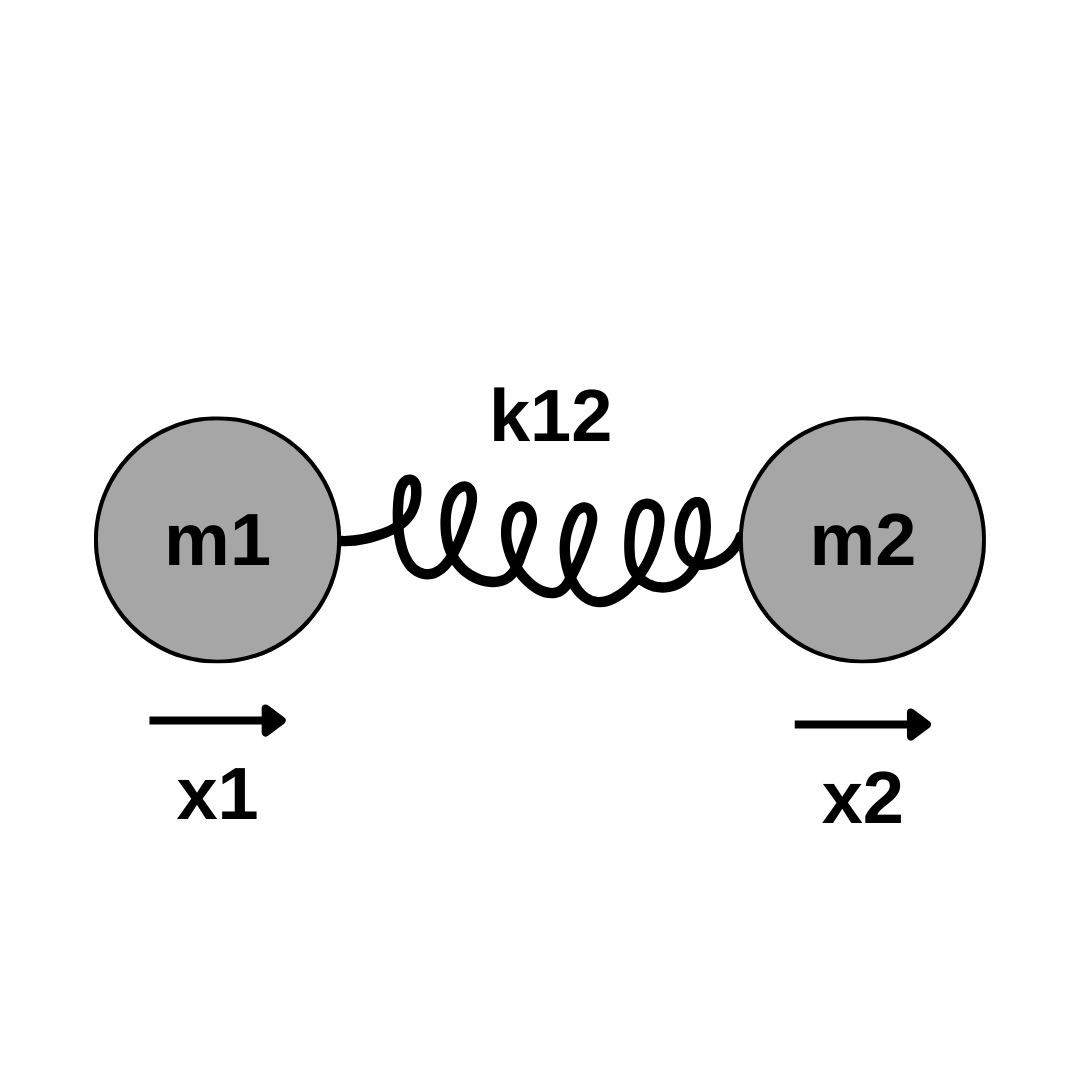


## Pre-Processing

Create necessary matrix and initial states using functions created in `ccho_helpers.py`

In [26]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from ccho_helpers import *
from classiq import *
from classiq.execution import ExecutionPreferences, ClassiqBackendPreferences

In [38]:
## Creating the 2 masses system

# Number of masses
N =2**1

# ass Matrix
M = np.array([[1,0],[0,1]])

# Spring Matrix
K = np.array([[0,1],[1,0]])

# Initial Conditions
x_0 = np.zeros([N,1])
xdot_0 = np.zeros([N,1])
x_0[1] = 1

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
Ham = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)
E0_y = calculate_energy(y_0, ydot_0, M, K)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("Initial Energy: ", E0_y)
print("B matrix: ", B)
print("Hamiltonian formed:", Ham)
print("Initial State:", init_state)

Initial Energy:  0.5
B matrix:  [[ 0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j]]
Hamiltonian formed: [[-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j  1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]]
Initial State: [[ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [-0.-1.j]
 [ 0.+0.j]
 [ 0.+0.j]]


## Pauli Matrix Decomposition

Create the Pauli List for the Hamiltonian. Pauli Decomposition is taken from [Classiq Library](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb) thanks a lot to the authors!

In [39]:
## Pauli Decomposition and transforming it into Classiq syntax

# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(Ham)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

100%|██████████| 64/64 [00:00<00:00, 26294.00it/s]

[('XII', (0.25+0j)), ('XIZ', (-0.25+0j)), ('XIX', (-0.25+0j)), ('XZI', (0.25+0j)), ('XZZ', (-0.25+0j)), ('XZX', (-0.25+0j)), ('YIY', (0.25+0j)), ('YZY', (0.25+0j))]


## Hamiltonian Simulation

We use the `exponantion_with_depth_constraint` function of classiq that produces a quantum gate that approximates $e^{iHt}$, for any input **Hermitian operator** $H$. Since the Hamiltonian for this algorithm is Hermitian by definition, exponentiation methods can be used straightforwardly.

In [40]:
# Add i phase for the last half
@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(np.pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)

# Main function with suzuki_trotter
@qfunc
def main(state: Output[QNum]):
    """
        Definition:
            Main function to make evolution

        Outputs:
            state (Output[QNum]): Resulting state at the t = evolution_coefficient
    """
        
    prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.00000000000001)
    init_state_phase(state)

    exponentiation_with_depth_constraint(
        classiq_pauli_list,
        evolution_coefficient=0.5,
        max_depth=500,
        qbv=state)

qmod = create_model(main)

In [41]:
#  Synthesis. Use "simulator_statevector" to take phases into account
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1, backend_preferences=backend_preferences))
qprog = synthesize(model_pref)
show(qprog)
write_qmod(qmod, "t=0.5Exponentiation1", decimal_precision=16)

Opening: https://platform.classiq.io/circuit/c640d357-b025-4392-bc58-6a563c7f3817?version=0.43.3


<img src="./Figures/ResourcesToyCase1EXP.png" alt="Toy Example" width="250"/>

In [42]:
# Execute the job
job = execute(qprog)
parsed_state_vector = job.result()[0].value.parsed_state_vector

## Post-Processing
- Obtain final state and derive final velocity and positions

In [43]:
# Combine the final results
state_amplitudes = sum_amplitudes_by_state(parsed_state_vector, N)

# Normalize the global phase
normalized_final_state = normalize_final_state(state_amplitudes, parsed_state_vector)

# Eliminate small numbers
simplified_final_state = simplify_final_state(normalized_final_state)

# Renormalize the final state using the norm of initial state
final_state = norm * simplified_final_state[..., None]

# Get the final position and velocity vectors
final_results = post_process_final_state(final_state, B_padded, N, y_0)
y_final = final_results["y_final"]
ydot_final = final_results["ydot_final"]

# Transform coordinates from y to x
x_final_results = back_coordinate_transformation(M, y_final, ydot_final)
x_final = x_final_results["x_final"]
xdot_final = x_final_results["xdot_final"]

print("Final Positions", x_final)
print("Final Velocities", xdot_final)

Final Positions [[0.11986601+0.j]
 [0.88013398+0.j]]
Final Velocities [[ 0.4593153 +0.j]
 [-0.45937138+0.j]]


## Classical Solution and Comparision
Obtain the result numerically

In [44]:
## Get classical results

def equations_of_motion(t, init, N, M, K):
    """
    Definition:
        EOM for classical coupled oscillator system with N masses
    Args:
        t (array): Time array
        init (list): Initial Conditions
        N (int): Number of masses
        M (array): Mass matrix (diagonal)
        K (array): Spring constant matrix
    Output:
        (list): List of final equations
    """

    x = init[:N]
    v = init[N:]
    dxdt = v
    dvdt = np.zeros(N)
    
    for i in range(N):
        if i == 0:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]
        elif i == N-1:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i])) / M[i, i]
        else:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i]) + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]

    return np.concatenate((dxdt, dvdt))


# Initial conditions: [x1(0), x2(0), ..., xN(0), v1(0), v2(0), ..., vN(0)]
initial_conditions = np.concatenate((x_0, xdot_0))


# Time span for the simulation
t_span = (0, 0.5)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the system of differential equations
solution = scipy.integrate.solve_ivp(equations_of_motion, t_span, initial_conditions.flatten(), t_eval=t_eval, args=(N, M, K))

# Extract the results
t = solution.t
x = solution.y[:N, :]
v = solution.y[N:, :]

# Get the results numerically
x_classic =np.array([x[0][-1], x[1][-1]])
xdot_classic =np.array([v[0][-1], v[1][-1]])

print("Position Vectors at t=0.5 classically")
print(x_classic)
print("Velocity Vectors at t=0.5 classically")
print(xdot_classic)


Position Vectors at t=0.5 classically
[0.11988439 0.88011561]
Velocity Vectors at t=0.5 classically
[ 0.45936539 -0.45936539]


In [45]:
## Compare classical and quantum results
# Compare two solutions
comparision = calculate_error(x_final, xdot_final, x_classic, xdot_classic, N)
amplitude_error = comparision["amplitude_error"]
sign_error = comparision["sign_error"]

for i in range(1, N+1):
    print(f"Error Percentage in Position of Mass {i}: ", amplitude_error[f"Position of Mass {i}"], "Sign Check: ", sign_error[f"Position of Mass {i}"])
    
for j in range(1, N+1):
    print(f"Error Percentage in Velocity of Mass {j}: ", amplitude_error[f"Velocity of Mass {j}"], "Sign Check: ", sign_error[f"Velocity of Mass {i}"])

Error Percentage in Position of Mass 1:  0.01533162758561238 Sign Check:  +
Error Percentage in Position of Mass 2:  0.002087656170664253 Sign Check:  +
Error Percentage in Velocity of Mass 1:  0.010904723246940085 Sign Check:  +
Error Percentage in Velocity of Mass 2:  0.0013024915626240145 Sign Check:  +


#### The results are very accurate for the first toy example. 

___
___

##  Toy Example 2
In this example, let exist two masses with $m_1 = 1$ and $m_2 = 1$. Also, assume spring constants are $\kappa_{11} = \kappa_{22} = 1$ and $\kappa_{12} = 1$. Initial states are chosen as $\vec{x}(t) = (0,1)^T$ and $\vec{\dot{x}}(t) = (1,1)^T$


In [16]:
## Creating the 2 masses system

# Number of masses
N =2**1

# ass Matrix
M = np.array([[1,0],[0,1]])

# Spring Matrix
K = np.array([[1,1],[1,1]])

# Initial Conditions
x_0 = np.array([[0],[1]])
xdot_0 = np.array([[1],[1]])

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
Ham = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)
E0_y = calculate_energy(y_0, ydot_0, M, K)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("Initial Energy: ", E0_y)
print("B matrix: ", B)
print("Hamiltonian formed:", Ham)
print("Initial State:", init_state)

Initial Energy:  2.0
B matrix:  [[ 1.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  1.+0.j]]
Hamiltonian formed: [[-0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -1.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j  1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]]
Initial State: [[ 1.+0.j]
 [ 1.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [-0.-1.j]
 [ 0.+1.j]
 [ 0.+0.j]]


In [17]:
# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(Ham)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

100%|██████████| 64/64 [00:00<00:00, 28268.27it/s]

[('XIZ', (-0.5+0j)), ('XIX', (-0.25+0j)), ('XZZ', (-0.5+0j)), ('XZX', (-0.25+0j)), ('XXX', (-0.25+0j)), ('XYY', (-0.25+0j)), ('YIY', (0.25+0j)), ('YZY', (0.25+0j)), ('YXY', (-0.25+0j)), ('YYX', (0.25+0j))]


In [32]:
# Add i phase for the last half
@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(np.pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)

# Main function with suzuki_trotter
@qfunc
def main(state: Output[QNum]):
    """
        Definition:
            Main function to make evolution

        Outputs:
            state (Output[QNum]): Resulting state at the t = evolution_coefficient
    """
        
    prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.0000000001)
    init_state_phase(state)

    exponentiation_with_depth_constraint(
        classiq_pauli_list,
        evolution_coefficient=0.5,
        max_depth=900,
        qbv=state)


In [33]:
# Create model and synthesis. Use "simulator_statevector" to take phases into account


qmod = create_model(main)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1, backend_preferences=backend_preferences))
qprog = synthesize(model_pref)
show(qprog)
write_qmod(qmod, "t=0.5Exponentiation", decimal_precision=16)


Opening: https://platform.classiq.io/circuit/ae9e990d-f434-455e-bd39-9c841b6fc830?version=0.43.3


In [34]:
# Execute the job
job = execute(qprog)
parsed_state_vector = job.result()[0].value.parsed_state_vector

In [35]:
# Combine the final results
state_amplitudes = sum_amplitudes_by_state(parsed_state_vector, N)

# Normalize the global phase
normalized_final_state = normalize_final_state(state_amplitudes, parsed_state_vector)

# Eliminate small numbers
simplified_final_state = simplify_final_state(normalized_final_state)

# Renormalize the final state using the norm of initial state
final_state = norm * simplified_final_state[..., None]

# Get the final position and velocity vectors
final_results = post_process_final_state(final_state, B_padded, N, y_0)
y_final = final_results["y_final"]
ydot_final = final_results["ydot_final"]

# Transform coordinates from y to x
x_final_results = back_coordinate_transformation(M, y_final, ydot_final)
x_final = x_final_results["x_final"]
xdot_final = x_final_results["xdot_final"]

print("Final Positions", x_final)
print("Final Velocities", xdot_final)

Final Positions [[0.5936723 +0.j]
 [1.24085981+0.j]]
Final Velocities [[ 1.29933939+0.j]
 [-0.02553784+0.j]]


## Classical Solution and Comparision
Obtain the result numerically

In [36]:
## Get classical results

def equations_of_motion(t, init, N, M, K):
    """
    Definition:
        EOM for classical coupled oscillator system with N masses
    Args:
        t (array): Time array
        init (list): Initial Conditions
        N (int): Number of masses
        M (array): Mass matrix (diagonal)
        K (array): Spring constant matrix
    Output:
        (list): List of final equations
    """

    x = init[:N]
    v = init[N:]
    dxdt = v
    dvdt = np.zeros(N)
    
    for i in range(N):
        if i == 0:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]
        elif i == N-1:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i])) / M[i, i]
        else:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i]) + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]

    return np.concatenate((dxdt, dvdt))


# Initial conditions: [x1(0), x2(0), ..., xN(0), v1(0), v2(0), ..., vN(0)]
initial_conditions = np.concatenate((x_0, xdot_0))


# Time span for the simulation
t_span = (0, 0.5)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the system of differential equations
solution = scipy.integrate.solve_ivp(equations_of_motion, t_span, initial_conditions.flatten(), t_eval=t_eval, args=(N, M, K))

# Extract the results
t = solution.t
x = solution.y[:N, :]
v = solution.y[N:, :]

# Get the results numerically
x_classic =np.array([x[0][-1], x[1][-1]])
xdot_classic =np.array([v[0][-1], v[1][-1]])

print("Position Vectors at t=0.5 classically")
print(x_classic)
print("Velocity Vectors at t=0.5 classically")
print(xdot_classic)


Position Vectors at t=0.5 classically
[0.59429062 1.24214278]
Velocity Vectors at t=0.5 classically
[ 1.2975731  -0.02183403]


In [37]:
## Compare classical and quantum results
# Compare two solutions
comparision = calculate_error(x_final, xdot_final, x_classic, xdot_classic, N)
amplitude_error = comparision["amplitude_error"]
sign_error = comparision["sign_error"]

for i in range(1, N+1):
    print(f"Error Percentage in Position of Mass {i}: ", amplitude_error[f"Position of Mass {i}"], "Sign Check: ", sign_error[f"Position of Mass {i}"])
    
for j in range(1, N+1):
    print(f"Error Percentage in Velocity of Mass {j}: ", amplitude_error[f"Velocity of Mass {j}"], "Sign Check: ", sign_error[f"Velocity of Mass {i}"])

Error Percentage in Position of Mass 1:  0.10404256517824492 Sign Check:  +
Error Percentage in Position of Mass 2:  0.10328638178086573 Sign Check:  +
Error Percentage in Velocity of Mass 1:  0.1361226174076713 Sign Check:  +
Error Percentage in Velocity of Mass 2:  16.96350335298973 Sign Check:  +


___

## Discussion and Results
Results show that, at least for the toy example, quantum algorithm works quite well. However, there are some points to be mentioned:

- In this file, we have shown that for the simplest case, using `exponentiation_with_depth_constraint` can give us a model with lower depths and nearly accurate results (in case 1), but there is a compromise with velocities(in case 2), we have found that increasing the depth limit would reduce the error percentage in velocities.
- Even though velocities are post-processed straightforwardly from the final state, positions can be computed uniquely only if $B$ is not singular. That is because of the $B^\dagger$ factor multiplying the amplitudes at the second half of the state. Positions can also be estimated using the sum of initial positions if there is no initial velocities since in that case, masses would displace in a way such that the absolute displacement can be protected. In our toy example, initial velocities equal to zero, so the results are pretty accurate. For general case, it is more reasonable to look at the fidelity of the final states computed classically and quantum algorithmically.
- State vector simulations are equivalent up to a global phase. We try to eliminate global phase by making the phase of first entry 0, yet that may create a sign flip in certain situations, which can result in reversed positions

___
___